# **Overfitting**

In the last notebook, you have implemented a CNN model for the Fashion MNIST dataset, by adding more layers and parameters, you should see improvement in the training set accuracy. But can your model generalize well to the unseen data? Can you see a degrade in the test set accuracy when adding more parameters? This is a phenomenon called **overfitting**.

\
In this notebook, you will experiment with different regularization techniques (i.e. dropout and L1/L2 regularizations) to deal with overfitting.
You are going to compare the ***underfitted model***, ***overfitted model*** and the ***regularized model*** with the ***baseline model***.

\
**Instruction: type your code when you see 'Type your code here' in comments**

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version:',tf.__version__)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
from sklearn.model_selection import train_test_split 
import os
print('Keras version:', tf.keras.__version__)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

Num GPUs Available:  0
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf


# Loading the Fashion MNIST dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
print(f'Shape of an image: {x_train[0].shape}')
print(f'Max pixel value: {x_train.max()}')
print(f'Min pixel value: {x_train.min()}')
print(f'Classes: {np.unique(y_train)}')

Shape of an image: (28, 28)
Max pixel value: 255
Min pixel value: 0
Classes: [0 1 2 3 4 5 6 7 8 9]


In [6]:
# Creating a list of labels

fashion_mnist_labels = ["T-shirt/top", 
                            "Trouser",
                            "Pullover",
                            "Dress",
                            "Coat",
                            "Sandal", 
                            "Shirt",
                            "Sneaker",
                            "Bag",
                            "Ankle boot"]

# Plotting some of the images

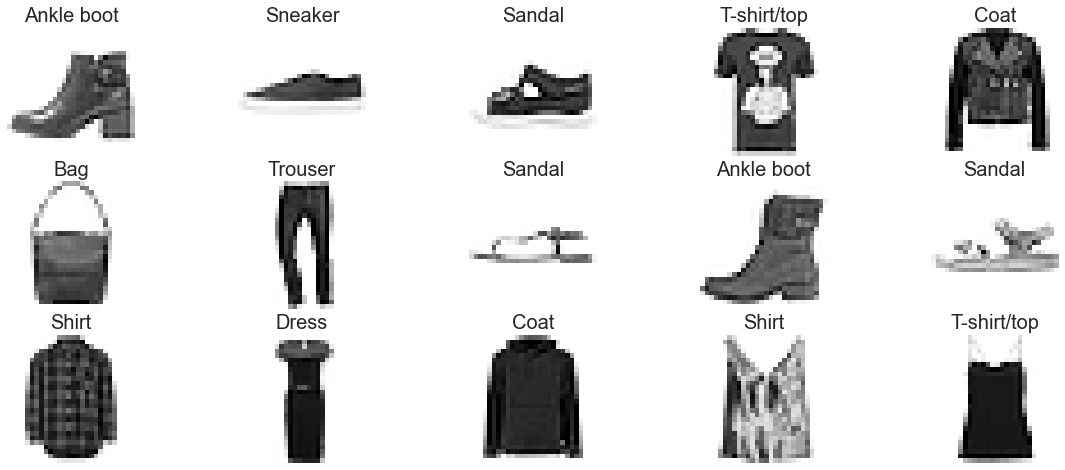

In [7]:
figure = plt.figure(figsize=(20,8))

indices = np.random.choice(np.arange(x_train.shape[0]), 15, replace=False)
subset = x_train[indices]

for i, image_sample in enumerate(subset):
  ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  j = fashion_mnist_labels[y_train[indices[i]]] #image label
  ax.set_title(j, fontsize=20)
  ax.imshow(image_sample.reshape(28,28))
  i+=1

In [8]:
x_train = x_train/255
x_test = x_test/255

num_classes = 10

train_one_hot = tf.keras.utils.to_categorical(y_train,num_classes)
test_one_hot = tf.keras.utils.to_categorical(y_test,num_classes)

print(y_train[0])
print(train_one_hot[0])

train_size = x_train.shape[0]
test_size = x_test.shape[0]


print(f'Max pixel value: {x_train.max()}')
print(f'Min pixel value: {x_train.min()}')
print(f'Train size: {train_size}, Test size: {test_size}')
print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')
print(f'Train label shape: {train_one_hot.shape}, Test label shape: {test_one_hot.shape}')


9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Max pixel value: 1.0
Min pixel value: 0.0
Train size: 60000, Test size: 10000
Train data shape: (60000, 28, 28), Test data shape: (10000, 28, 28)
Train label shape: (60000, 10), Test label shape: (10000, 10)


# **Model training**

In [9]:
batch_size = 100
epoch = 2000


es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=40,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)


## **Baseline model**

In [10]:
BASELINE_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+BASELINE_INPUT_SHAPE)
x_test = x_test.reshape([-1]+BASELINE_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1), Test data shape: (10000, 28, 28, 1)


In [11]:
tf.keras.backend.clear_session()

inputs = Input(shape=BASELINE_INPUT_SHAPE)

x = Conv2D(filters=10, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(50, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

baseline_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="baseline_model")

baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 10)        170       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                98050     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 98,730
Trainable params: 98,730
Non-trainable params: 0
________________________________________________

2021-09-25 11:59:15.351868: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-25 11:59:15.353279: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
baseline_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


baseline_hist = baseline_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

Train on 42000 samples, validate on 18000 samples
Epoch 1/2000
42000/42000 [==============================] - 59s 1ms/sample - loss: 0.5618 - accuracy: 0.8041 - val_loss: 0.4141 - val_accuracy: 0.8515
Epoch 2/2000
42000/42000 [==============================] - 57s 1ms/sample - loss: 0.3686 - accuracy: 0.8723 - val_loss: 0.3577 - val_accuracy: 0.8751
Epoch 3/2000
42000/42000 [==============================] - 58s 1ms/sample - loss: 0.3301 - accuracy: 0.8830 - val_loss: 0.3415 - val_accuracy: 0.8806
Epoch 4/2000
42000/42000 [==============================] - 59s 1ms/sample - loss: 0.3005 - accuracy: 0.8926 - val_loss: 0.3048 - val_accuracy: 0.8938
Epoch 5/2000
42000/42000 [==============================] - 59s 1ms/sample - loss: 0.2803 - accuracy: 0.9009 - val_loss: 0.3004 - val_accuracy: 0.8942
Epoch 6/2000
42000/42000 [==============================] - 61s 1ms/sample - loss: 0.2670 - accuracy: 0.9039 - val_loss: 0.2893 - val_accuracy: 0.8983
Epoch 7/2000
42000/42000 [==================

## **Underfitted model**

In [ ]:
UNDERFIT_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+UNDERFIT_INPUT_SHAPE)
x_test = x_test.reshape([-1]+UNDERFIT_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

In [ ]:
tf.keras.backend.clear_session()


inputs = Input(shape=UNDERFIT_INPUT_SHAPE)

x = Conv2D(filters=1, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(5, activation='relu')(x) 

outputs = Dense(num_classes, activation='softmax')(x)

underfitted_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="underfitted_model")


underfitted_model.summary()

In [ ]:
underfitted_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


underfitted_hist = underfitted_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

## **Overfitted model**

In [ ]:
OVERFIT_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+OVERFIT_INPUT_SHAPE)
x_test = x_test.reshape([-1]+OVERFIT_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

In [ ]:
tf.keras.backend.clear_session()



inputs = Input(shape=OVERFIT_INPUT_SHAPE)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1),
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(1000, activation='relu')(x)

x = Dense(64, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

overfitted_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="overfitted_model")

overfitted_model.summary()


In [ ]:
overfitted_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

overfitted_hist = overfitted_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

# Regularized model

## Task:

The regularized model has the same architecture as the overfitted model.
Apply regularization techniques to the regularized model, see what is the best test set accuracy you can achieve, and compare it with the overfitted model.



**Links to the documentation for your reference:**

Dropout:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

L1/L2 regularization:
https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer








In [ ]:
REGULARIZED_INPUT_SHAPE = [28,28,1]

x_train = x_train.reshape([-1]+REGULARIZED_INPUT_SHAPE)
x_test = x_test.reshape([-1]+REGULARIZED_INPUT_SHAPE)

print(f'Train data shape: {x_train.shape}, Test data shape: {x_test.shape}')

In [ ]:
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()


#Type your code here

inputs = Input(shape=REGULARIZED_INPUT_SHAPE)

x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), 
           activation='relu', padding='same')(inputs)

x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)


x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)


x = Conv2D(filters=64, kernel_size=(4,4), strides=(1,1) , activation='relu')(x)
                    
x = MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(1000, activation='relu')(x)

x = Dense(64, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

regularized_model = tf.keras.Model(inputs=inputs,outputs=outputs, name="regularized_model")


regularized_model.summary()


In [ ]:
regularized_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

regularized_hist = regularized_model.fit(x_train, train_one_hot, epochs=epoch, batch_size = batch_size,
          validation_split=0.3, callbacks=[es])

# **Plotting the learning curves**

In [ ]:
baseline_hist_df = pd.DataFrame(baseline_hist.history)
columns = {'loss':'Baseline train loss','accuracy':'Baseline train acc','val_loss':'Baseline val loss','val_accuracy':'Baseline val acc'}
baseline_hist_df.rename(columns=columns, inplace=True)


In [ ]:
underfitted_hist_df = pd.DataFrame(underfitted_hist.history)
columns = {'loss':'Underfit train loss','accuracy':'Underfit train acc','val_loss':'Underfit val loss','val_accuracy':'Underfit val acc'}
underfitted_hist_df.rename(columns=columns, inplace=True)


In [ ]:
overfitted_hist_df = pd.DataFrame(overfitted_hist.history)
columns = {'loss':'Overfit train loss','accuracy':'Overfit train acc','val_loss':'Overfit val loss','val_accuracy':'Overfit val acc'}
overfitted_hist_df.rename(columns=columns, inplace=True)


In [ ]:
regularized_hist_df = pd.DataFrame(regularized_hist.history)
columns = {'loss':'Regularized train loss','accuracy':'Regularized train acc','val_loss':'Regularized val loss','val_accuracy':'Regularized val acc'}
regularized_hist_df.rename(columns=columns, inplace=True)


In [ ]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(underfitted_hist_df['Underfit train acc'], color='C1', linestyle='-',label='Underfit train acc')
plt.plot(underfitted_hist_df['Underfit val acc'], color='C1', linestyle='--',label='Underfit val acc')

plt.ylim([0.7,1])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(overfitted_hist_df['Overfit train acc'], color='C2', linestyle='-',label='Overfit train acc')
plt.plot(overfitted_hist_df['Overfit val acc'], color='C2', linestyle='--',label='Overfit val acc')

plt.ylim([0.7,1.05])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


In [ ]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')


plt.plot(regularized_hist_df['Regularized train acc'], color='C3', linestyle='-',label='Regularized train acc')
plt.plot(regularized_hist_df['Regularized val acc'], color='C3', linestyle='--',label='Regularized val acc')

plt.ylim([0.7,1.])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


In [ ]:
plt.figure(figsize=(12,8))

plt.plot(baseline_hist_df['Baseline train acc'], color='C0', linestyle='-',label='Baseline train acc')
plt.plot(baseline_hist_df['Baseline val acc'], color='C0', linestyle='--',label='Baseline val acc')

plt.plot(overfitted_hist_df['Overfit train acc'], color='C2', linestyle='-',label='Overfit train acc')
plt.plot(overfitted_hist_df['Overfit val acc'], color='C2', linestyle='--',label='Overfit val acc')

plt.plot(regularized_hist_df['Regularized train acc'], color='C3', linestyle='-',label='Regularized train acc')
plt.plot(regularized_hist_df['Regularized val acc'], color='C3', linestyle='--',label='Regularized val acc')

plt.ylim([0.7,1.05])

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)


# **Model evaluation on test set**

In [ ]:
scores = baseline_model.evaluate(x_test.reshape([-1]+BASELINE_INPUT_SHAPE), test_one_hot, verbose=1)
names = baseline_model.metrics_names

for i in range(len(scores)):
  print(f'Baseline model test {names[i]}: {scores[i]:.4f}')

In [ ]:
scores = underfitted_model.evaluate(x_test.reshape([-1]+UNDERFIT_INPUT_SHAPE), test_one_hot, verbose=1)
names = underfitted_model.metrics_names

for i in range(len(scores)):
  print(f'Underfitted model test {names[i]}: {scores[i]:.4f}')

In [ ]:
scores = overfitted_model.evaluate(x_test.reshape([-1]+OVERFIT_INPUT_SHAPE), test_one_hot, verbose=1)
names = overfitted_model.metrics_names

for i in range(len(scores)):
  print(f'Overfitted model test {names[i]}: {scores[i]:.4f}')

In [ ]:
scores = regularized_model.evaluate(x_test.reshape([-1]+REGULARIZED_INPUT_SHAPE), test_one_hot, verbose=1)
names = regularized_model.metrics_names

for i in range(len(scores)):
  print(f'Regularized model test {names[i]}: {scores[i]:.4f}')

# Making predictions and plotting the result

In [ ]:
prediction = regularized_model.predict(x_test)


figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    ax.imshow(x_test[index].reshape(28,28), cmap='gray')
    predict_index = np.argmax(prediction[index])
    true_index = np.argmax(test_one_hot[index])
   
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))